In [1]:
# Util
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep and Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import PrecisionRecallDisplay

# Modeling
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
# Plot Size
sns.set(rc={'figure.figsize': (11.7, 8.27)})

## Data Load

In [4]:
# Read in csv data
slot_performance = pd.read_csv("../data/slot_performance.csv")
slot_performance.start_date = pd.to_datetime(slot_performance.start_date, format='%m/%d/%Y')
slot_performance.end_date = pd.to_datetime(slot_performance.end_date, format='%m/%d/%Y')
location = pd.read_csv("../data/location.csv")

In [5]:
con = sqlite3.connect('../data/glassdoor.db')
slot_performance.to_sql('slot_performance', con, if_exists='replace', index=False)
location.to_sql('location', con, if_exists='replace', index=False)

## PART A: Write SQL queries to answer the following questions

#### Total Contract Value is defined as the total amount that customers committed to spend. Write a SQL query that returns the Total Contract Value ('total_contract_value' field) for each state (name) by month (using 'start_date') in the provided datasets.

In [6]:
q = '''
SELECT
    l.state_name,
    strftime('%Y-%m', p.start_date) AS year_month,
    SUM(p.total_contract_value) AS total_contract_value
FROM
    slot_performance AS p
JOIN
    location AS l
ON
    l.city_id = p.city_id
GROUP BY
    state_name,
    year_month
'''
cv = pd.read_sql(q, con)
cv.head(3)

,state_name,year_month,total_contract_value
0,California,2016-04,17665
1,California,2016-05,85040
2,California,2016-06,102885


#### For all employers who purchased >1 product with Glassdoor, write a SQL query to return the 'job_slots' and 'click_marketplace_value' values for the second transaction by employer.

In [7]:
q = '''
WITH transactions AS (
    SELECT
        employer_id,
        start_date,
        job_slots,
        click_marketplace_value,
        ROW_NUMBER() OVER (
            PARTITION BY employer_id
            ORDER BY start_date
        ) AS transaction_num
    FROM
        slot_performance
)
SELECT
    employer_id,
    job_slots,
    click_marketplace_value
FROM
    transactions
WHERE
    transaction_num = 2
'''
transaction2 = pd.read_sql(q, con)
transaction2.head(3)

,employer_id,job_slots,click_marketplace_value
0,95253,15,3420.0
1,231360,15,0.0
2,266960,15,2920.7


## PART B: Metric Design

#### What metrics would you propose to measure the quality of services Glassdoor provided to our clients? 

I suggest using a *Return on Investment* variable to track how much value employers recieved from Glassdoor in exchange for the job slot total contract fee.

Here I defined ROI as

`ROI` = `apply_start_clicks` / (`days in contract` * `total contract value`)

1st, there is a time normalization step.  A few companies only held the job slot product for a few days.  By taking clicks per month we put all contracts on the same playing field.

2nd, I used the `apply_start_clicks` variable rather than the number of completed applications.  My assumption is that if a Glassdoor user clicks on a job slot but doesn't finish the application the application process may be too cumbersome.  Getting a user to click on a job slot is the main focus here so `apply_start_clicks` is more relevant than completed applications.

3rd, although there are many factors companies will consider in terms of job recruiting services (ease of use, quality of applicants, etc) the most straight forward measure of efficiency is dollars per click.  In this case many contracts had no clicks so clicks per dollar represents the same concept without undefined values.

#### How does performance vary in terms of:

- job_slots?
- total_contract_value?
- click_marketplace_value?

In [8]:
q = '''SELECT * FROM slot_performance'''
sp = pd.read_sql(q, con)
sp.start_date = pd.to_datetime(sp.start_date)
sp.end_date = pd.to_datetime(sp.end_date)
sp['days'] = sp.apply(
    lambda row: (row['end_date'] - row['start_date']).days,
    axis=1
)
sp['monthly_clicks'] = sp['apply_start_clicks'] / sp['days'] * 30
sp['ROI'] = sp['monthly_clicks'] / sp['total_contract_value']

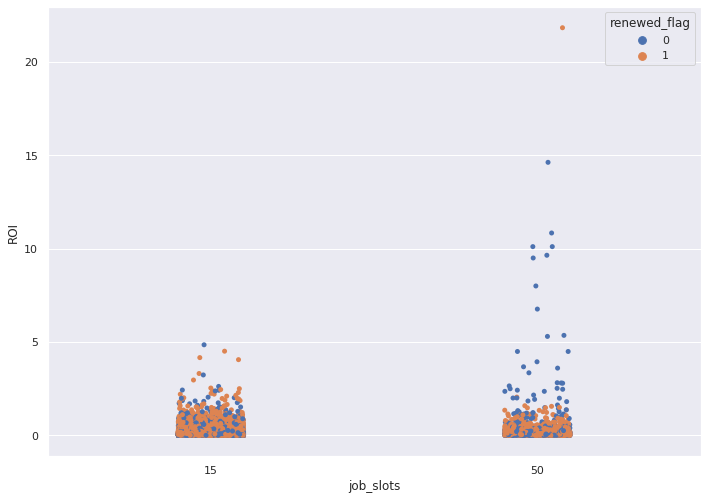

In [9]:
_ = sns.stripplot(x='job_slots', y='ROI', hue='renewed_flag', data=sp)

In [10]:
sp.groupby('job_slots').agg(mean_ROI = ('ROI', 'mean'))

,mean_ROI
job_slots,
15,0.099567
50,0.252803


Looking at the marginal distributions shows that the 50 job slot option provides 2.5 times the return on investment

In reality however, this relationship is masked by the click marketplace variable.  The 50 job slot options tend to get prioritized more in the bidding algorithm.

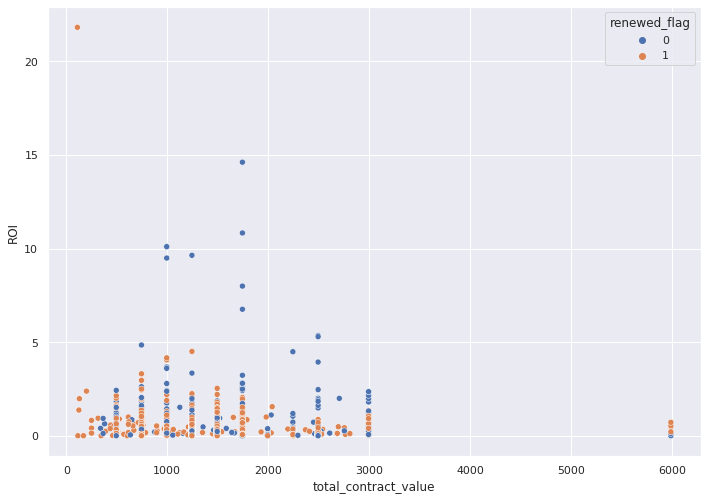

In [11]:
_ = sns.scatterplot(x='total_contract_value', y='ROI', hue='renewed_flag', data=sp)

There is not much to say about total contract value since it is already included in the definition of ROI.

The only interesting observation is that high ROI contracts tend not to be renewed in a lot of cases.

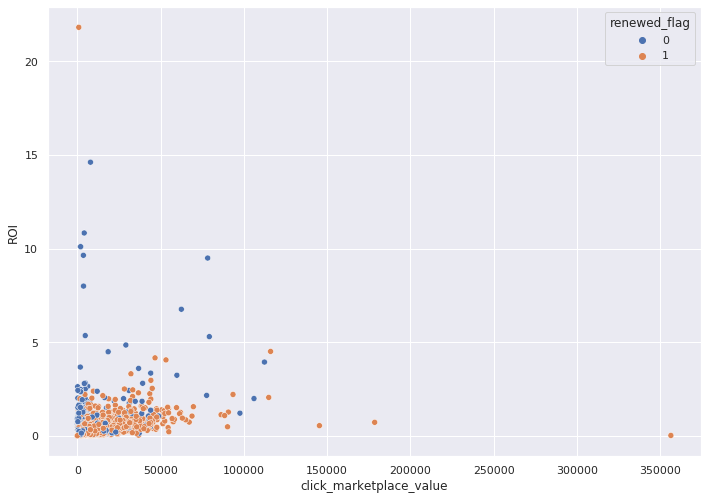

In [12]:
_ = sns.scatterplot(x='click_marketplace_value', y='ROI', hue='renewed_flag', data=sp)

This graph shows that click marketplace value seems to support customer retention and ROI seems to be almost a disincentive. Perhaps customers are frusterated when they are overwhelmed with applications from low quality candidates and prefer only a targeted set of applications.

## PART C: Retention Modeling and Analysis

I'll define two new features used for modeling:
 - *Cost Ratio*: ratio of click marketplace value to total contract value
 - *Post Completion Ratio*: How often customers replace the job posting occupying a job slot.
 
It looks like there is some class separation in the marginal distributions of these variables given customer renewal

In [13]:
sp['cost_ratio'] =  sp['click_marketplace_value'] / sp['total_contract_value']
sp['post_completion_ratio'] = sp['job_listings'] / sp['job_slots']

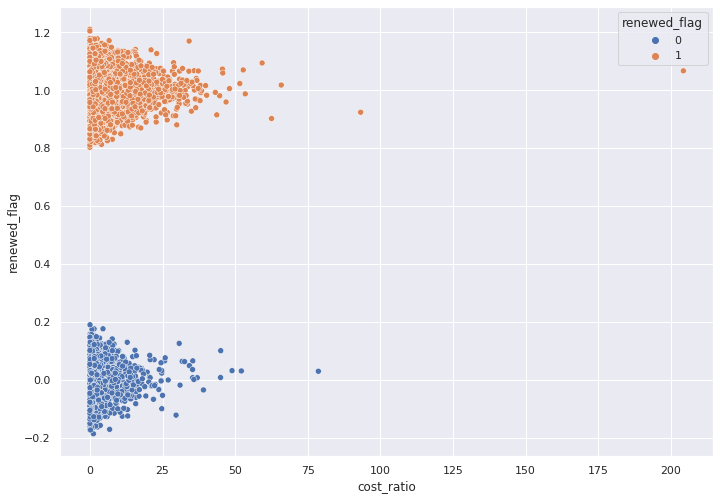

In [14]:
def jitter(values, mu, sig):
    return values + np.random.normal(mu, sig, values.shape)

g = sns.scatterplot(
    x=sp.cost_ratio,
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)

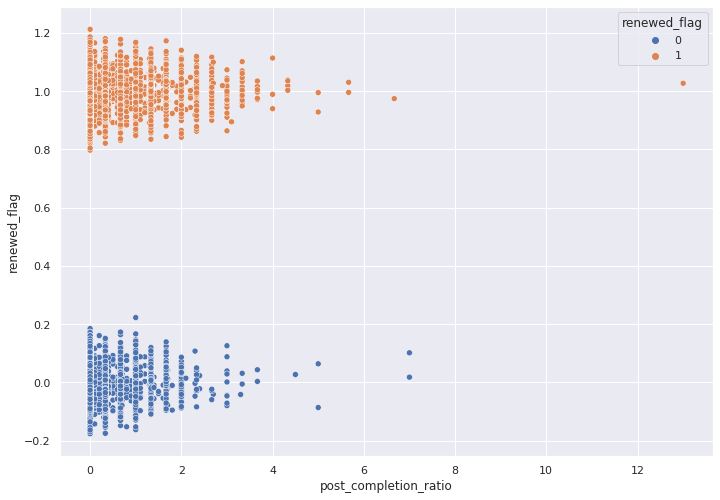

In [15]:
g = sns.scatterplot(
    x=sp.post_completion_ratio,
    y=jitter(sp.renewed_flag, 0, 0.05),
    hue=sp.renewed_flag
)

Next, I fit a logistic regression model to predict customer retention based on a set of features.

I chose logistic regression since it was simple and interpretable, not because it provides to best prediction.
I also experimented with XGBOOSt and found that it may provide better prediction, but both models illustrated 
that the core problem at hand is in precision and recall.  
Most contracts (~70%) are renewed anyway so this must be taken into account in the decision rule.

In [16]:
features = [
    'job_slots', 'total_contract_value', 
    'click_marketplace_value', 'cost_ratio', 
    'post_completion_ratio'
]

data = sp[features]
scaler = StandardScaler()
scaler.fit(data)

data = pd.DataFrame(scaler.transform(data))
data.columns = features

X_train, X_test, y_train, y_test = train_test_split(
    data, 
    sp.renewed_flag,
    test_size = 0.2,
    stratify=sp.renewed_flag
)

logreg = LogisticRegression(solver='liblinear', penalty='l1')
logreg.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

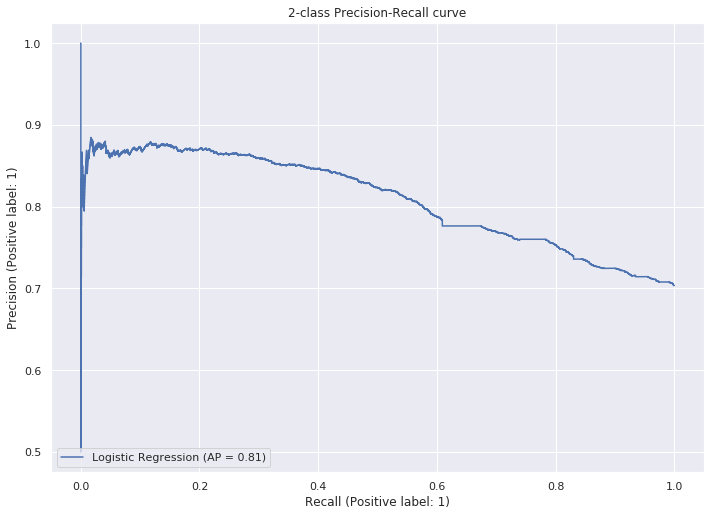

In [17]:
display = PrecisionRecallDisplay.from_estimator(
    logreg, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### Which factors or combination of factors best predict an employer's likelihood to retain (i.e. renewed_flag = 1)? And how well does your chosen model predict retention? Please list any assumptions you made in the modeling process and explain why you chose your methodology.
 
 


The cost ratio is the most important feature in customer retention. (Customers want to get good quality applicants for their fee to glassdoor)

The total contract value is also important.

Customers who actively swap out job postings in the job slots are also more likely to renew a contract.

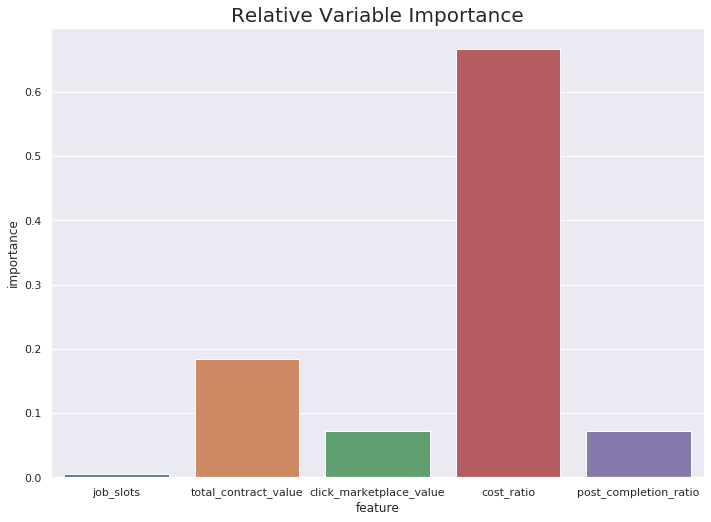

In [18]:
importance = logreg.coef_[0]
# plot feature importance
importance = abs(importance)
importance = importance / importance.sum()
importance = pd.DataFrame({'feature': features, 'importance': importance})
g = sns.barplot(x='feature', y='importance', data=importance)
_ = g.axes.set_title("Relative Variable Importance",fontsize=20)

This model has a lower precision than I would like, but very high recall.

In customer retention, false positive errors (predicting churn when customers are quite happy) 
would result in wasted resources when the bidding algorithm boosts job slots that already have enough good candidates.
False negative errors would result in loosing customers to churn because we didn't identify there is an issue with the Glassdoor-customer relationship.

Both problems are bad but false negative errors are potentially worse.

As a result, we need to tune the decision rule to boost precision at the expense of recall.
We can use the f1 score to do this according to the graph below.

In [19]:
y_preds = logreg.predict_proba(X_test)[:,1]
y_pred_class = logreg.predict(X_test)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true=y_test, 
    y_pred=y_pred_class, 
    average='binary'
)
print(f"precision:\t {precision:.3f}")
print(f"recall:\t\t {recall:.3f}")
print(f"F1:\t\t {f1:.3f}")

precision:	 0.706
recall:		 0.997
F1:		 0.827


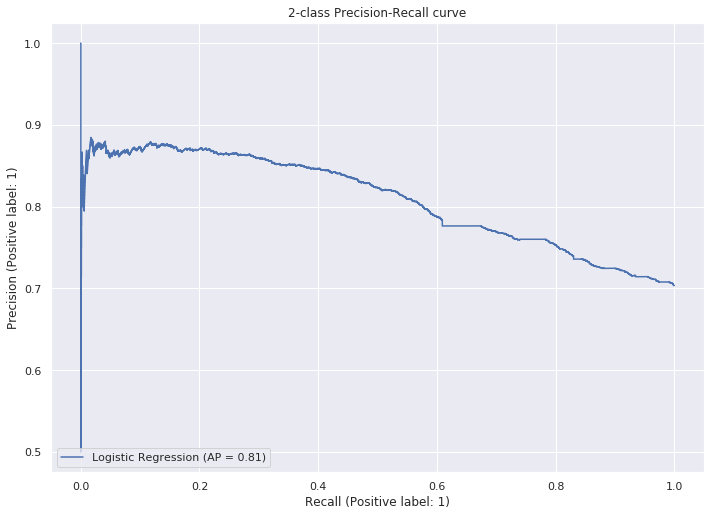

In [20]:
display = PrecisionRecallDisplay.from_estimator(
    logreg, X_test, y_test, name="Logistic Regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### Based on your analysis, what modifications would you recommend we make to our ad platform algorithm to improve retention?

The bidding algorithm should take customer spending into account in some way, either via `total_contract value` or `cost_ratio`.

Glassdoor should take a customer swapping a job posting out in a job slot as a sign that the job posting may be filled.  
Glassdoor should prioritize the job slots of customers who have not yet filled a role if it wants to retain this employer as a customer.


In [21]:
## Close DB Connection
con.close()